In [1]:
import numpy as np
import pandas as pd
import os
import random
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from keras_tuner import Hyperband
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, f1_score
import seaborn as sns
from tensorflow.keras.layers import LSTM, Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Reshape, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
DATA_PATH = './data/images'
RNN_IMAGE_RESULTS = './results/rnn/images'
RNN_HISTORY_RESULTS = './results/rnn/history'
RNN_REPORT_RESULTS = './results/rnn/reports'
RNN_MODEL_RESULTS = './results/rnn/models'

TRAIN_DIRECTORY = 'train'
VALIDATION_DIRECTORY = 'val'
TEST_DIRECTORY = 'test'

SUB_DIRECTORIES = [TRAIN_DIRECTORY, TEST_DIRECTORY, VALIDATION_DIRECTORY]
CATEGORY_DIRECTORIES = ['Chickenpox', 'Cowpox', 'Healthy', 'HFMD', 'Measles', 'Monkeypox']

In [3]:
def count_images(dir_name):
    for dataset_type in SUB_DIRECTORIES:
        total = 0
        dir_type = os.path.join(dir_name, dataset_type)
        print(f"============ {dataset_type} dataset ===========")
        for category in os.listdir(dir_type):
            category_path = os.path.join(dir_type, category)
            if not os.path.isdir(category_path):
                continue
            images = [img for img in os.listdir(category_path) if img.endswith(('jpg','jpeg'))]
            print(f"Number of images in {category_path.split('/')[-1]}: {len(images)}")
            total += len(images)
        print(f"Total image count: {total}")
        print("")

In [4]:
count_images(DATA_PATH)

============ train dataset ===========
Number of images in Cowpox: 800
Number of images in Healthy: 800
Number of images in HFMD: 800
Number of images in Measles: 748
Number of images in Chickenpox: 800
Number of images in Monkeypox: 800
Total image count: 4748

============ test dataset ===========
Number of images in Cowpox: 100
Number of images in Healthy: 100
Number of images in HFMD: 100
Number of images in Measles: 94
Number of images in Chickenpox: 100
Number of images in Monkeypox: 100
Total image count: 594

============ val dataset ===========
Number of images in Cowpox: 100
Number of images in Healthy: 100
Number of images in HFMD: 100
Number of images in Measles: 93
Number of images in Chickenpox: 100
Number of images in Monkeypox: 100
Total image count: 593



In [5]:
def load_images_to_df(base_path, dataset_type):
    path = os.path.join(base_path, dataset_type)
    image_dir = Path(path)

    file_paths = list(image_dir.glob(r'**/*.jpg'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_paths))

    file_paths = pd.Series(file_paths, name='Path').astype(str)
    labels = pd.Series(labels, name='Label')

    image_df = pd.concat([file_paths, labels], axis=1)

    samples = []
    for record in image_df['Label'].unique():
        samples.append(image_df[image_df['Label']==record])
    image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)

    return image_df

In [6]:
df_train = load_images_to_df(DATA_PATH, TRAIN_DIRECTORY)
df_train.head(10)

,Path,Label
0,data/images/train/Healthy/HEALTHY_69_01_0_3962...,Healthy
1,data/images/train/Chickenpox/CHP_16_01_0_3194.jpg,Chickenpox
2,data/images/train/Cowpox/CWP_15_01_0_5158.jpg,Cowpox
3,data/images/train/Measles/MSL_16_01_0_3338.jpg,Measles
4,data/images/train/Monkeypox/MKP_65_01_0_2905.jpg,Monkeypox
5,data/images/train/Monkeypox/MKP_108_01_0_6757.jpg,Monkeypox
6,data/images/train/Healthy/HEALTHY_30_01_0_7765...,Healthy
7,data/images/train/HFMD/HFMD_03_01_0_114.jpg,HFMD
8,data/images/train/Healthy/HEALTHY_04_01_0_4417...,Healthy
9,data/images/train/Chickenpox/CHP_14_01_0_1461.jpg,Chickenpox


In [7]:
df_val = load_images_to_df(DATA_PATH, VALIDATION_DIRECTORY)
df_val.head(10)

,Path,Label
0,data/images/val/Cowpox/CWP_14_01_0_4369.jpg,Cowpox
1,data/images/val/Cowpox/CWP_29_01_0_726.jpg,Cowpox
2,data/images/val/HFMD/HFMD_66_02_0_1643.jpg,HFMD
3,data/images/val/Chickenpox/CHP_02_01_0_1320.jpg,Chickenpox
4,data/images/val/Healthy/HEALTHY_52_01_0_6779.jpg,Healthy
5,data/images/val/Measles/MSL_08_01_0_8564.jpg,Measles
6,data/images/val/Measles/MSL_23_01_0_2983.jpg,Measles
7,data/images/val/Monkeypox/MKP_78_01_0_7004.jpg,Monkeypox
8,data/images/val/Healthy/HEALTHY_32_02_0_4352.jpg,Healthy
9,data/images/val/Healthy/HEALTHY_11_01_ORIGINAL...,Healthy


In [8]:
df_test = load_images_to_df(DATA_PATH, TEST_DIRECTORY)
df_test.head(10)

,Path,Label
0,data/images/test/Cowpox/CWP_30_01_0_2732.jpg,Cowpox
1,data/images/test/HFMD/HFMD_119_01_0_9236.jpg,HFMD
2,data/images/test/Healthy/HEALTHY_20_01_0_1790.jpg,Healthy
3,data/images/test/HFMD/HFMD_65_01_0_381.jpg,HFMD
4,data/images/test/Measles/MSL_31_01_0_4215.jpg,Measles
5,data/images/test/HFMD/HFMD_64_01_0_1715.jpg,HFMD
6,data/images/test/Chickenpox/CHP_30_01_0_3593.jpg,Chickenpox
7,data/images/test/Monkeypox/MKP_24_02_0_6264.jpg,Monkeypox
8,data/images/test/Cowpox/CWP_05_02_0_5037.jpg,Cowpox
9,data/images/test/Healthy/HEALTHY_65_01_0_7956.jpg,Healthy


In [9]:
def pie_plot_from_df(df, title):
    pie = df["Label"].value_counts()
    pie.plot(kind="pie", autopct="%1.2f%%")
    plt.ylabel("")
    plt.xlabel(title)
    plt.show()

In [10]:
def show_images_from_df(df, nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,8), subplot_kw={"xticks":[], "yticks":[]})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df.Path[i], -1))
        ax.set_title(df.Label[i])
    plt.tight_layout()
    plt.show()

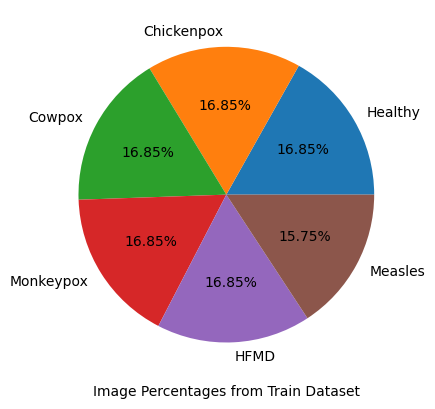

In [11]:
pie_plot_from_df(df_train, "Image Percentages from Train Dataset")

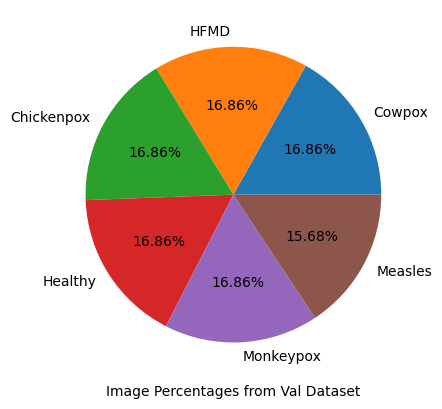

In [12]:
pie_plot_from_df(df_val, "Image Percentages from Val Dataset")

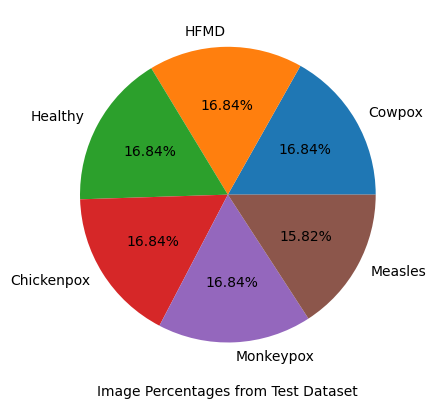

In [13]:
pie_plot_from_df(df_test, "Image Percentages from Test Dataset")

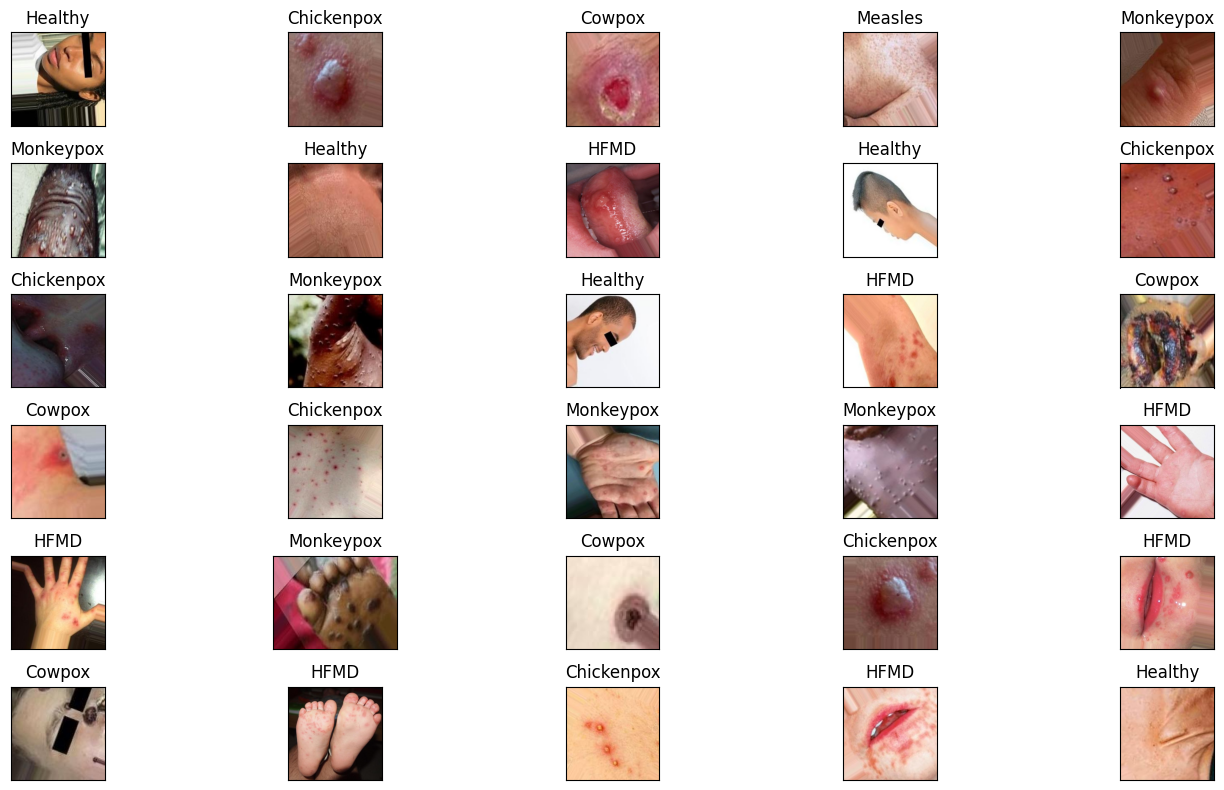

In [14]:
show_images_from_df(df_train, 6, 5)

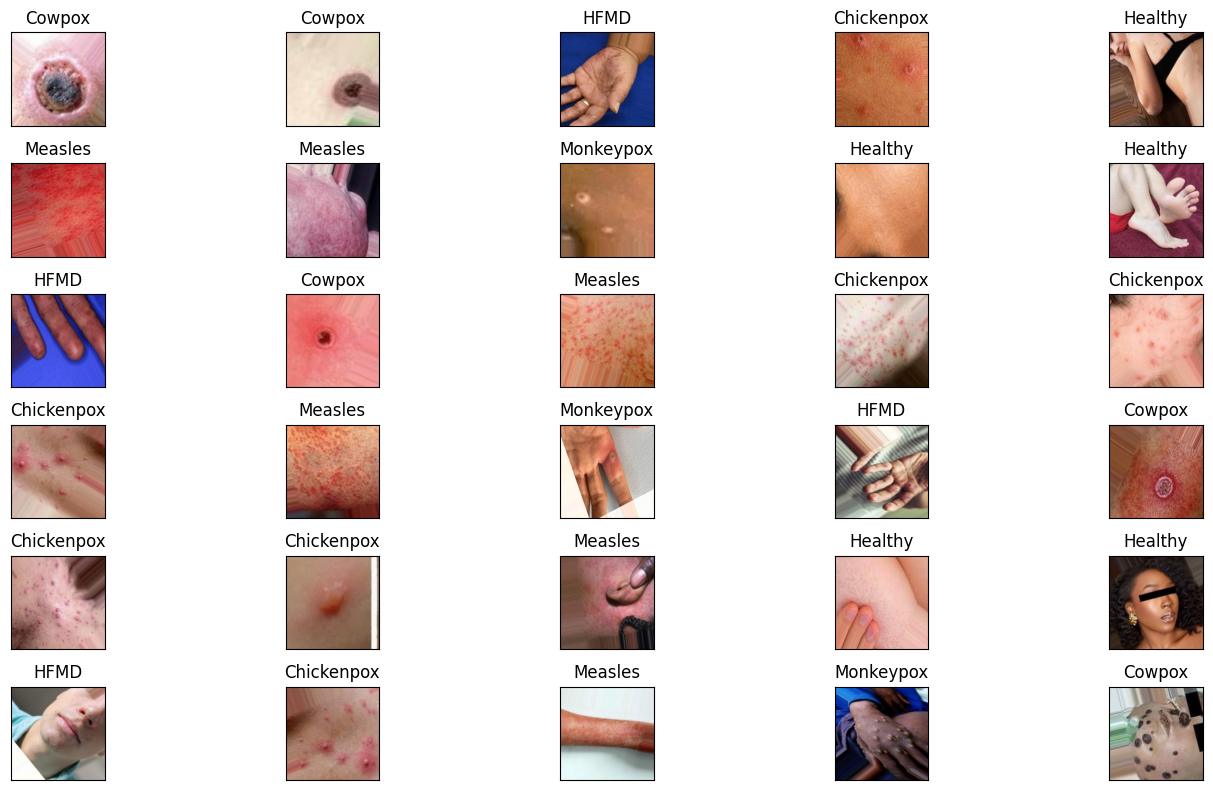

In [15]:
show_images_from_df(df_val, 6, 5)

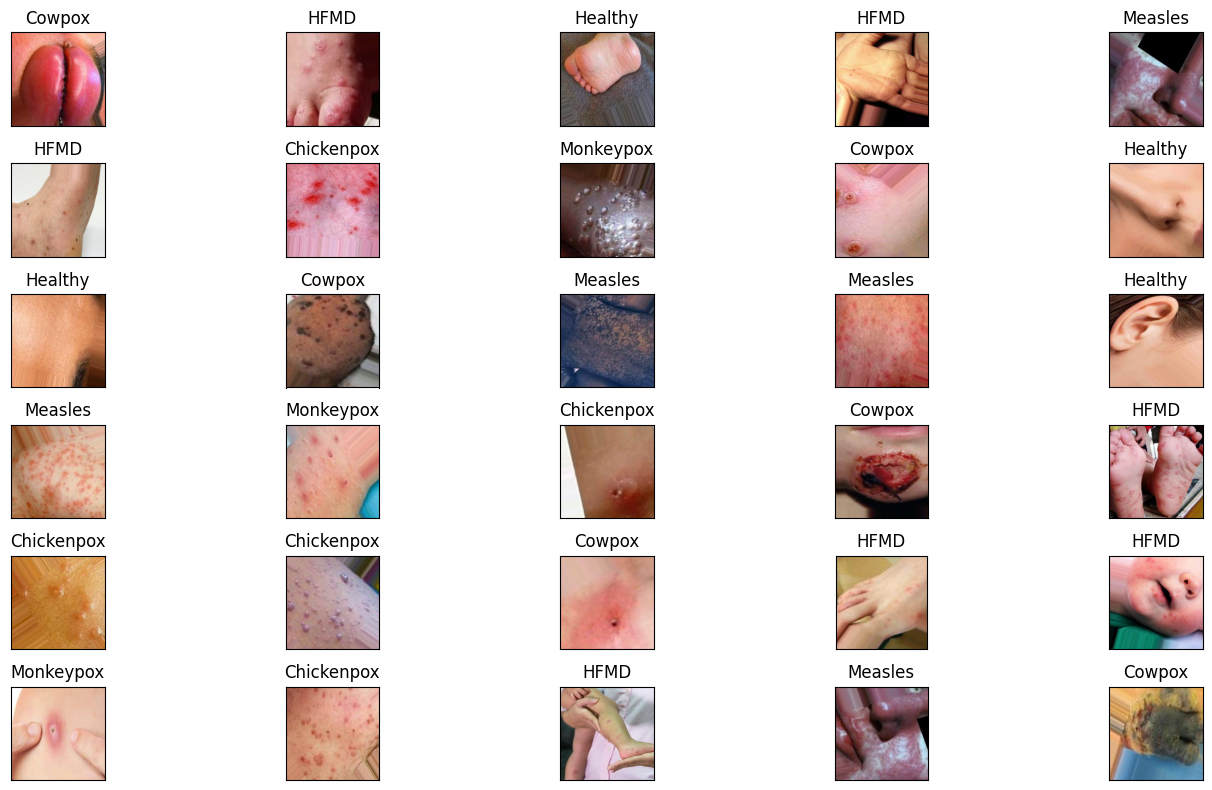

In [16]:
show_images_from_df(df_test, 6, 5)

In [17]:
def preprocess_images(df):
    images = []
    labels = []
    for index, row in df.iterrows():
        img = tf.keras.utils.load_img(row['Path'], target_size=(224, 224))
        img_array = tf.keras.utils.img_to_array(img)/255.0
        img_array = img_array.reshape(224, -1)
        images.append(img_array)
        labels.append(row['Label'])
    return np.array(images), np.array(labels)

In [18]:
train_images, train_labels = preprocess_images(df_train)
val_images, val_labels = preprocess_images(df_val)
test_images, test_labels = preprocess_images(df_test)

In [19]:
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)
test_labels = label_encoder.transform(test_labels)

In [20]:
train_labels = to_categorical(train_labels, len(CATEGORY_DIRECTORIES))
val_labels = to_categorical(val_labels, len(CATEGORY_DIRECTORIES))
test_labels = to_categorical(test_labels, len(CATEGORY_DIRECTORIES))

## Model Based on Random Values

2025-03-14 01:08:30.088879: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-03-14 01:08:30.088929: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-14 01:08:30.088932: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-14 01:08:30.089159: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-14 01:08:30.089179: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


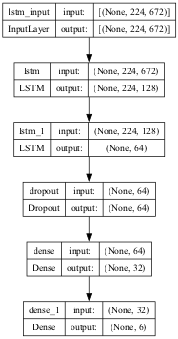

In [21]:
model = Sequential()

model.add(LSTM(units=128, return_sequences=True, input_shape=(224, 224 * 3)))
model.add(LSTM(units=64))
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu"))
model.add(Dense(len(CATEGORY_DIRECTORIES), activation="softmax"))

tf.keras.utils.plot_model(model, f"{RNN_IMAGE_RESULTS}/lstm_model_summary.png", show_shapes=True, dpi=50)

In [22]:
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=20,
    mode="min",
    restore_best_weights=True,
    verbose=1
)

In [23]:
# Get history
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels),
                    batch_size=32, epochs=100, callbacks=[early_stopping])

Epoch 1/100


2025-03-14 01:08:35.551662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-14 01:08:35.717737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-14 01:08:35.781653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-14 01:08:35.948140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  3/149 [..............................] - ETA: 4s - loss: 1.8934 - categorical_accuracy: 0.1979  

2025-03-14 01:08:36.040254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


149/149 [==============================] - ETA: 0s - loss: 1.8165 - categorical_accuracy: 0.1862

2025-03-14 01:08:41.835117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-14 01:08:41.898486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-14 01:08:41.936523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


149/149 [==============================] - 8s 41ms/step - loss: 1.8165 - categorical_accuracy: 0.1862 - val_loss: 1.7882 - val_categorical_accuracy: 0.1771
Epoch 2/100
149/149 [==============================] - 5s 35ms/step - loss: 1.8061 - categorical_accuracy: 0.1765 - val_loss: 1.7848 - val_categorical_accuracy: 0.2057
Epoch 3/100
149/149 [==============================] - 5s 35ms/step - loss: 1.7970 - categorical_accuracy: 0.1725 - val_loss: 1.7889 - val_categorical_accuracy: 0.1973
Epoch 4/100
149/149 [==============================] - 6s 37ms/step - loss: 1.7918 - categorical_accuracy: 0.1883 - val_loss: 1.7827 - val_categorical_accuracy: 0.1990
Epoch 5/100
149/149 [==============================] - 5s 35ms/step - loss: 1.7906 - categorical_accuracy: 0.1912 - val_loss: 1.7853 - val_categorical_accuracy: 0.1922
Epoch 6/100
149/149 [==============================] - 5s 34ms/step - loss: 1.7905 - categorical_accuracy: 0.1849 - val_loss: 1.7722 - val_categorical_accuracy: 0.2074
Epoc

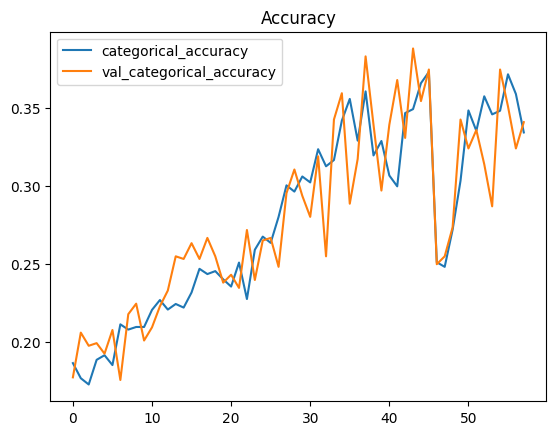

<Figure size 640x480 with 0 Axes>

In [24]:
pd.DataFrame(history.history)[['categorical_accuracy','val_categorical_accuracy']].plot()
plt.title("Accuracy")
plt.show()
plt.savefig(f"{RNN_IMAGE_RESULTS}/lstm_accuracy_plot.png")

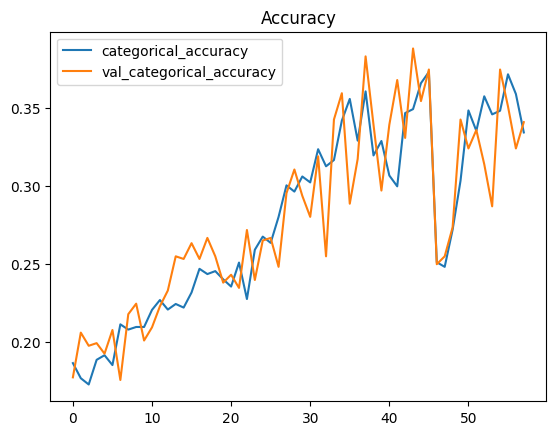

<Figure size 640x480 with 0 Axes>

In [25]:
pd.DataFrame(history.history)[['categorical_accuracy','val_categorical_accuracy']].plot()
plt.title("Accuracy")
plt.show()
plt.savefig(f"{RNN_IMAGE_RESULTS}/lstm_accuracy_plot.png")

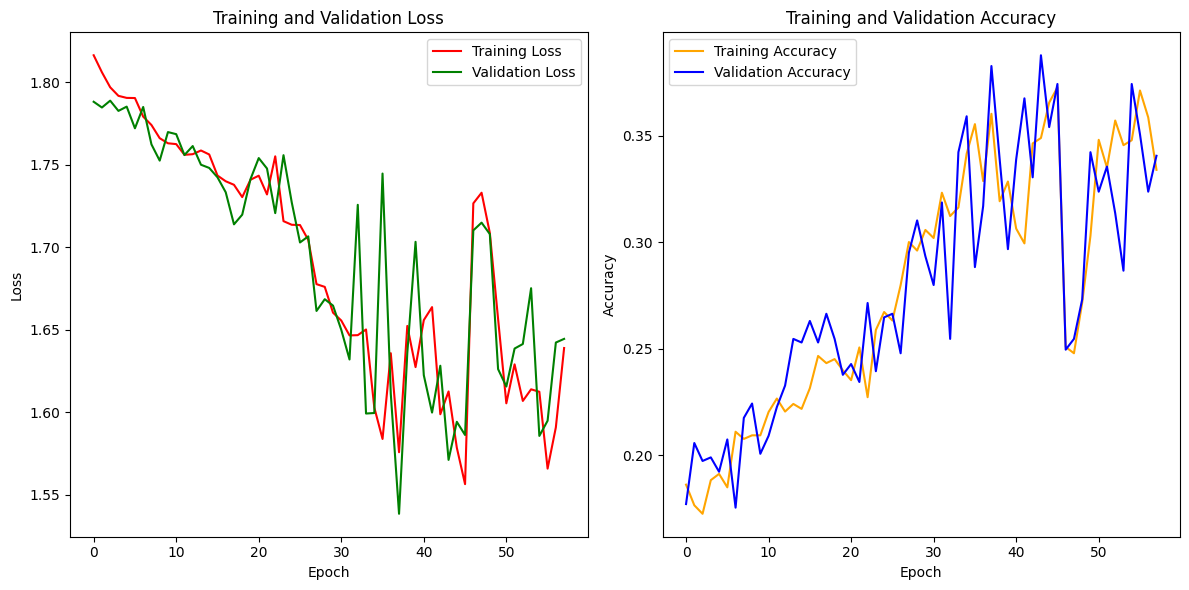

In [26]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'red', label='Training Loss')
plt.plot(history.history['val_loss'], 'green', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], 'orange', label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], 'blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

plt.savefig(f"{RNN_IMAGE_RESULTS}/lstm_training_plots.png")
history_df = pd.DataFrame(history.history)
history_csv = f"{RNN_HISTORY_RESULTS}/lstm_history.csv"
history_df.to_csv(history_csv)

In [27]:
y_pred = model.predict(test_images)

y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(y_pred, axis=1)

2025-03-14 01:13:39.622640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-14 01:13:39.754923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-14 01:13:39.818742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 1s 12ms/step


In [28]:
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

report_file = f"{RNN_REPORT_RESULTS}/lstm_classification_report.txt"
with open(report_file, 'w') as file:
    file.write(report)

Classification Report:
               precision    recall  f1-score   support

  Chickenpox       0.43      0.41      0.42       100
      Cowpox       0.53      0.42      0.47       100
        HFMD       0.52      0.37      0.43       100
     Healthy       0.28      0.40      0.33       100
     Measles       0.36      0.50      0.42        94
   Monkeypox       0.33      0.24      0.28       100

    accuracy                           0.39       594
   macro avg       0.41      0.39      0.39       594
weighted avg       0.41      0.39      0.39       594



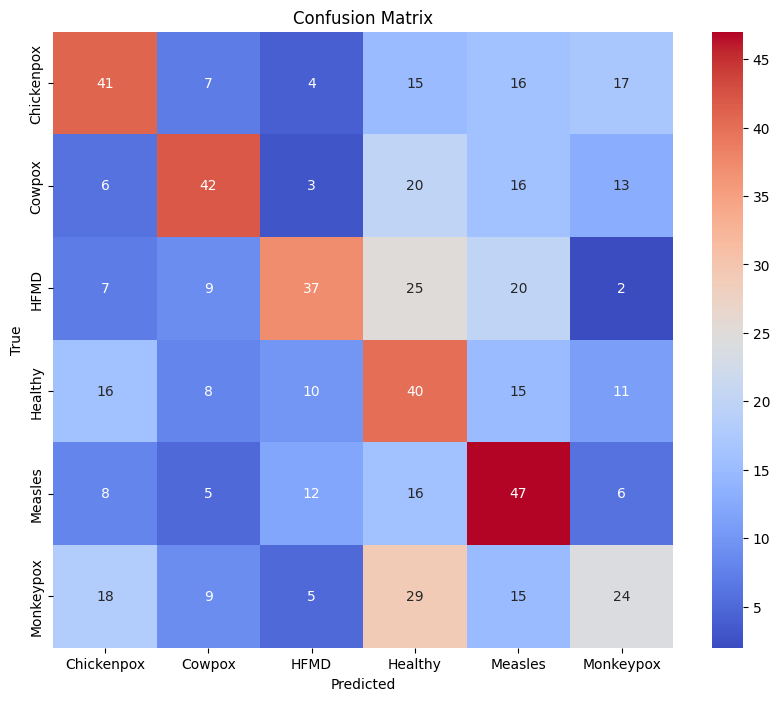

In [29]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

heatmap_file = f'{RNN_IMAGE_RESULTS}/lstm_confusion_matrix.png'
plt.savefig(heatmap_file)

In [30]:
model.save(f"{RNN_MODEL_RESULTS}/lstm.h5")

## Hyper-parameter Tuned Model

In [31]:
def build_model_lstm(hp):
    model = Sequential()

    model.add(LSTM(units=hp.Int('units_lstm_1', min_value=64, max_value=256, step=64),
    input_shape=(224, 224 * 3),
    return_sequences=True))

    model.add(LSTM(units=hp.Int('units_lstm_2', min_value=32, max_value=128, step=32)))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_dense', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dense(len(CATEGORY_DIRECTORIES), activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'])

    return model

In [32]:
stop_early=EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)

In [34]:
tuner = RandomSearch(
        build_model_lstm,
        objective="val_categorical_accuracy",
        max_trials=5,
        executions_per_trial=1,
        directory="hyperparameter_tuning",
        project_name='LSTM'
    )

tuner.search(train_images, train_labels, validation_data=(val_images, val_labels), epochs=20, callbacks=[stop_early])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
print(f"""
Best hyperparameters:
- Units in LSTM Layer 1: {best_hps.get('units_lstm_1')}
- Units in LSTM Layer 2: {best_hps.get('units_lstm_2')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- Units in Dense Layer 1: {best_hps.get('units_dense')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Trial 5 Complete [00h 02m 27s]
val_categorical_accuracy: 0.3372681140899658

Best val_categorical_accuracy So Far: 0.3372681140899658
Total elapsed time: 00h 11m 12s

Best hyperparameters:
- Units in LSTM Layer 1: 192
- Units in LSTM Layer 2: 96
- Dropout Rate: 0.2
- Units in Dense Layer 1: 32
- Learning Rate: 0.001



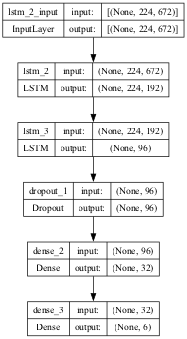

In [35]:
model = tuner.hypermodel.build(best_hps)

tf.keras.utils.plot_model(model, f"{RNN_IMAGE_RESULTS}/lstm_model_hp_summary.png", show_shapes=True, dpi=50)

In [36]:
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels),
                    batch_size=32, epochs=100, callbacks=[stop_early])

Epoch 1/100


2025-03-14 02:02:49.059360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-14 02:02:49.339490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-14 02:02:49.402227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-14 02:02:49.522431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  3/149 [..............................] - ETA: 6s - loss: 2.0247 - categorical_accuracy: 0.1562  

2025-03-14 02:02:49.616214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


149/149 [==============================] - ETA: 0s - loss: 1.8323 - categorical_accuracy: 0.1618

2025-03-14 02:02:56.916256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-14 02:02:56.989202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-14 02:02:57.041541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


149/149 [==============================] - 9s 52ms/step - loss: 1.8323 - categorical_accuracy: 0.1618 - val_loss: 1.8021 - val_categorical_accuracy: 0.1838
Epoch 2/100
149/149 [==============================] - 6s 42ms/step - loss: 1.8066 - categorical_accuracy: 0.1778 - val_loss: 1.7939 - val_categorical_accuracy: 0.1956
Epoch 3/100
149/149 [==============================] - 6s 42ms/step - loss: 1.8048 - categorical_accuracy: 0.1813 - val_loss: 1.7856 - val_categorical_accuracy: 0.2040
Epoch 4/100
149/149 [==============================] - 7s 44ms/step - loss: 1.7985 - categorical_accuracy: 0.1995 - val_loss: 1.7814 - val_categorical_accuracy: 0.1939
Epoch 5/100
149/149 [==============================] - 6s 43ms/step - loss: 1.7878 - categorical_accuracy: 0.1965 - val_loss: 1.7678 - val_categorical_accuracy: 0.2040
Epoch 6/100
149/149 [==============================] - 7s 46ms/step - loss: 1.7860 - categorical_accuracy: 0.2013 - val_loss: 1.7807 - val_categorical_accuracy: 0.2142
Epoc

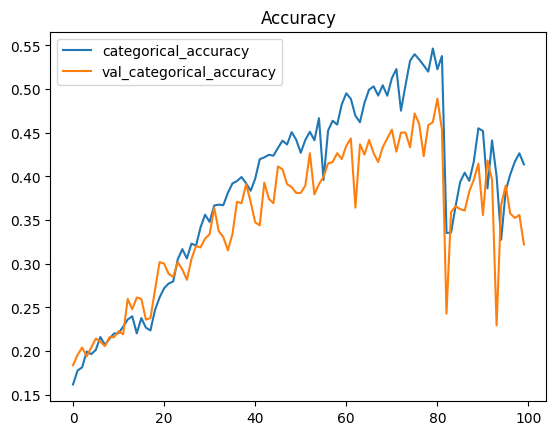

<Figure size 640x480 with 0 Axes>

In [37]:
pd.DataFrame(history.history)[['categorical_accuracy','val_categorical_accuracy']].plot()
plt.title("Accuracy")
plt.show()
plt.savefig(f"{RNN_IMAGE_RESULTS}/lstm_hp_accuracy_plot.png")

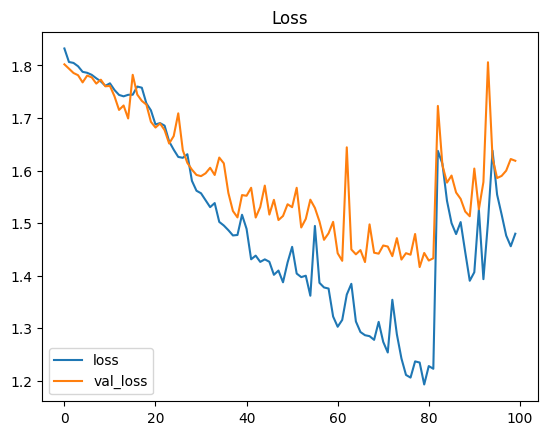

<Figure size 640x480 with 0 Axes>

In [38]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()
plt.savefig(f"{RNN_IMAGE_RESULTS}/lstm_hp_loss_plot.png")

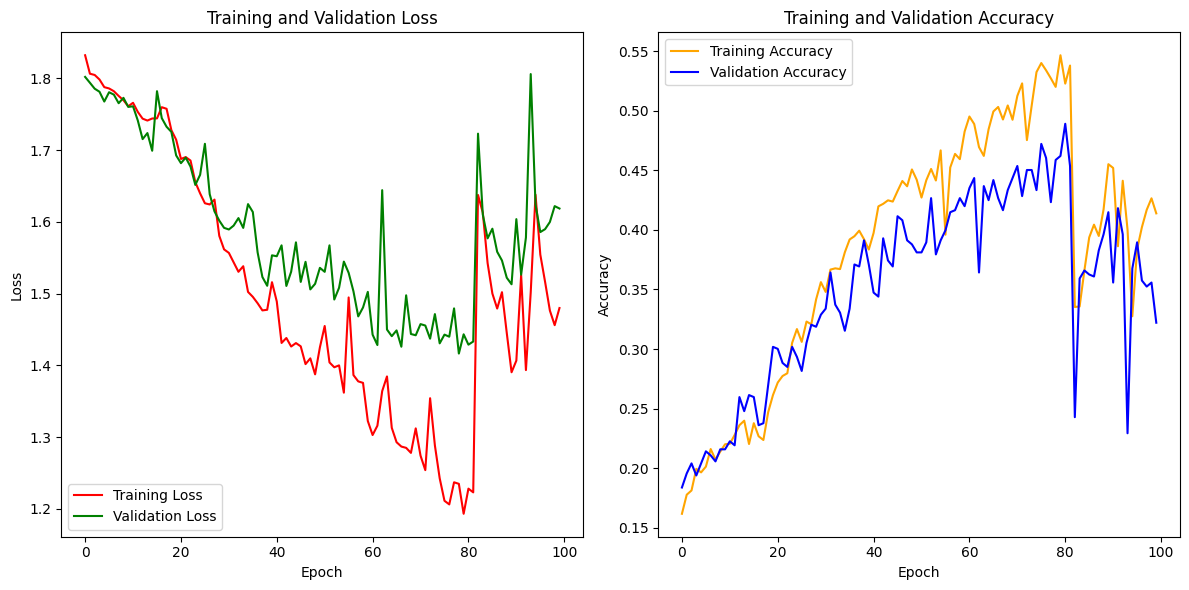

In [39]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'red', label='Training Loss')
plt.plot(history.history['val_loss'], 'green', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], 'orange', label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], 'blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

plt.savefig(f"{RNN_IMAGE_RESULTS}/lstm_training_hp_plots.png")
history_df = pd.DataFrame(history.history)
history_csv = f"{RNN_HISTORY_RESULTS}/lstm_hp_history.csv"
history_df.to_csv(history_csv)

In [40]:
y_pred = model.predict(test_images)

y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(y_pred, axis=1)

 1/19 [>.............................] - ETA: 28s

2025-03-14 02:13:28.479126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-14 02:13:28.548721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-14 02:13:28.603696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 2s 14ms/step


In [41]:
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

report_file = f"{RNN_REPORT_RESULTS}/lstm_hp_classification_report.txt"
with open(report_file, 'w') as file:
    file.write(report)

Classification Report:
               precision    recall  f1-score   support

  Chickenpox       0.39      0.46      0.42       100
      Cowpox       0.43      0.43      0.43       100
        HFMD       0.23      0.49      0.31       100
     Healthy       0.50      0.21      0.30       100
     Measles       0.32      0.17      0.22        94
   Monkeypox       0.25      0.18      0.21       100

    accuracy                           0.32       594
   macro avg       0.35      0.32      0.32       594
weighted avg       0.35      0.32      0.32       594



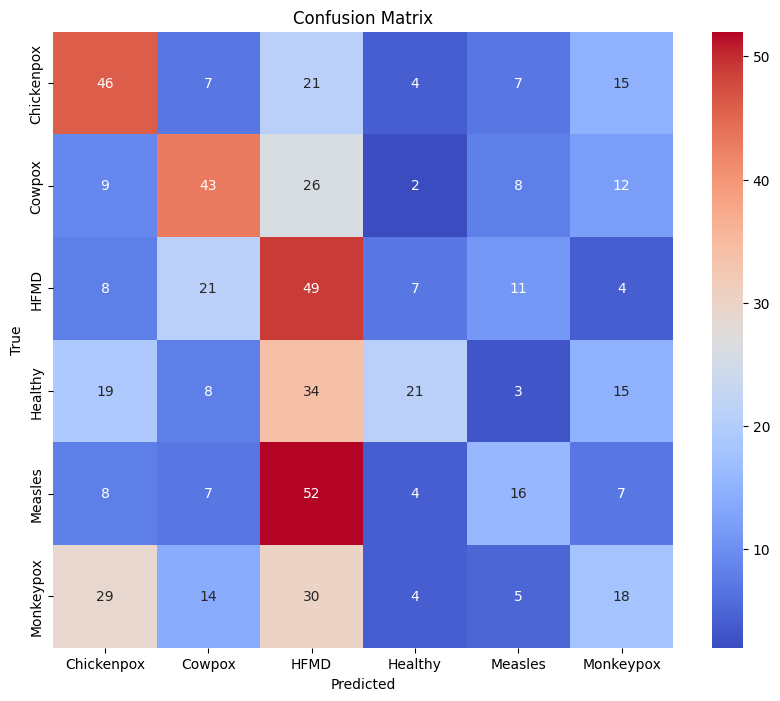

In [42]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

heatmap_file = f'{RNN_IMAGE_RESULTS}/lstm_hp_confusion_matrix.png'
plt.savefig(heatmap_file)

In [43]:
model.save(f"{RNN_MODEL_RESULTS}/lstm_hp.h5")